In [1]:
import metaSI
import numpy as np
from matplotlib import pyplot as plt
import torch

$$T_{slinger} = 2 \pi / \omega_0$$

$$T_{rev} =  \gamma 2 \pi / u$$

$$f_0^d = f_0^t \Delta t = \Delta t \omega_0/2 \pi$$

In [2]:
def get_data(ulist, elist=None, omega0=1, gamma=0.5, dt=None, output_noise=0):
    omega = 0
    theta = 0
    domegadt = lambda theta, omega, u: -omega0**2*np.sin(theta) - gamma*omega + u
    dfdt = lambda x,u: np.array([x[1], domegadt(x[0], x[1], u)])
    x = np.array([theta, omega])
    elist = np.random.uniform(low=-0.8, high=0.8, size=len(ulist))
    ylist = []
    for u,e in zip(ulist,elist):
        ylist.append(x[0])
        unow = u*(1 + e)
        k1 = dt*dfdt(x,unow)
        k2 = dt*dfdt(x+k1/2,unow)
        k3 = dt*dfdt(x+k2/2,unow)
        k4 = dt*dfdt(x+k3,unow)
        x = x + (k1+2*k2+2*k3+k4)/6
    return np.array(ylist) + np.random.normal(scale=output_noise,size=len(ulist))

Tslinger 6.283185307179586
Trev 3.141592653589793
dt 0.3141592653589793


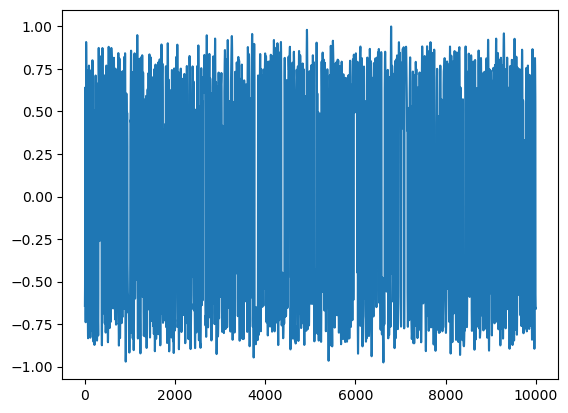

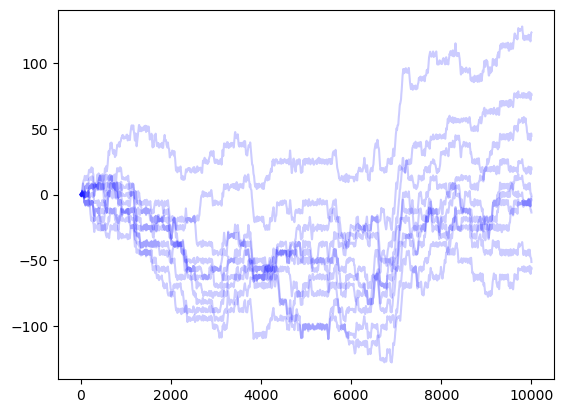

52.405719349842876


In [3]:
omega0 = 1
uamp = 1.0
gamma = 0.5
print('Tslinger',2*np.pi/omega0)
print('Trev',gamma*2*np.pi/uamp)

Ndis = 20 #was 10
dt = 2*np.pi/omega0/Ndis
print('dt',dt)
fscale = 2
fmax = dt*omega0/(2*np.pi)*fscale

N = 10000
q = 5
from deepSI.exp_design import filtered_signal
u = filtered_signal(N,fmax=fmax,q=q)*uamp
plt.plot(u)
plt.show()

Y = []
for _ in range(10):
    ylist = get_data(u,omega0=omega0, dt=dt)
    Y.append(ylist)
    plt.plot(ylist,'b',alpha=0.2)
plt.show()
print(np.std(np.array(Y)[:,-1]))

In [4]:
# for _ in range(10):
#     plt.plot(get_data([0.5]*100+[0]*100),'b')
# plt.show()

In [5]:


from metaSI.data import System_data,Norm

In [6]:
Ntrain = 50_000
Nval = 20_000
Ntest = 50_000

u_train = filtered_signal(Ntrain,fmax=fmax,q=q,rng=1)*uamp
u_val = filtered_signal(Nval,fmax=fmax,q=q,rng=2)*uamp
u_test = filtered_signal(Ntest,fmax=fmax,q=q,rng=3)*uamp
y_train = get_data(u_train, omega0=omega0,dt=dt, gamma=gamma)
y_val = get_data(u_val, omega0=omega0,dt=dt, gamma=gamma)
y_test = get_data(u_test, omega0=omega0,dt=dt, gamma=gamma)

train = System_data(u_train, y_train)
val = System_data(u_val, y_val)
test = System_data(u_test, y_test)

# assert np.all(abs(train.y)<np.pi)
# assert np.all(abs(val.y)<np.pi)
# assert np.all(abs(test.y)<np.pi)


In [7]:
N_realizations = 5000
N_transient = 100
N_realizations_len = 100 #was 100

u_realisation_full = filtered_signal(N_transient+N_realizations_len,fmax=fmax,q=q,rng=4)*uamp
u_realisation = u_realisation_full[N_transient:]

from tqdm.auto import tqdm
y_realizations = []
for i in tqdm(range(N_realizations)):
    y_realizations.append(get_data(u_realisation_full, omega0=omega0,dt=dt, gamma=gamma)[N_transient:])
y_realizations = np.array(y_realizations).T


  0%|          | 0/5000 [00:00<?, ?it/s]

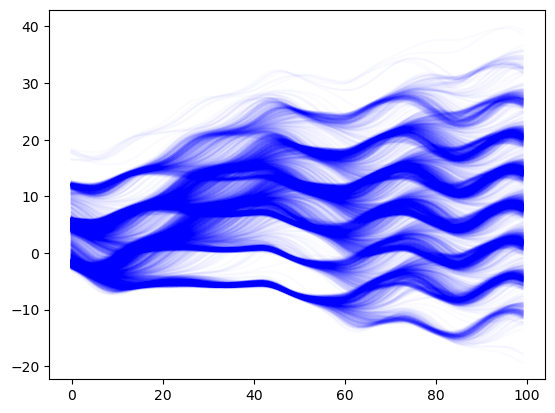

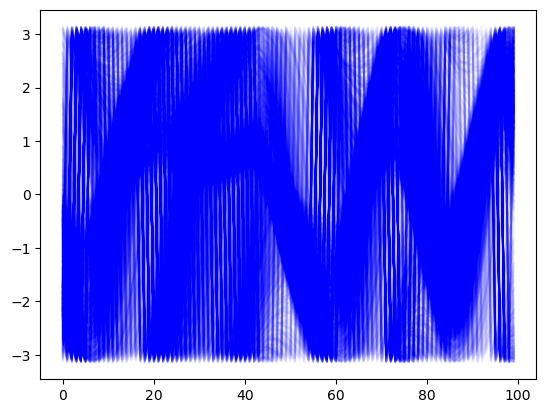

In [8]:
plt.plot(y_realizations,'b', alpha=0.02)
plt.show()
plt.plot((y_realizations+np.pi)%(2*np.pi) - np.pi,'b', alpha=0.02)
plt.show()

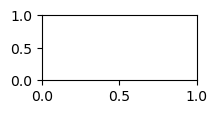

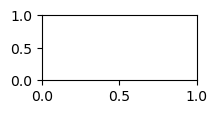

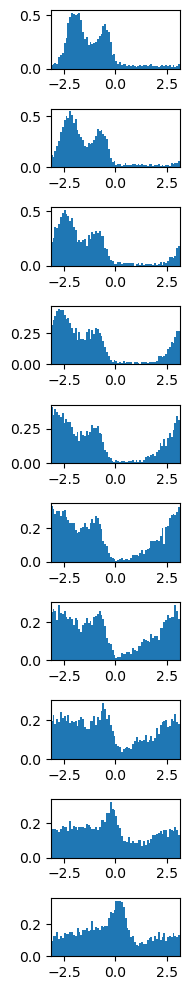

In [11]:

nplots = 10
plt.figure(figsize=(2,1*nplots))
for t in range(nplots):
    plt.subplot(nplots,1,t+1)
    plt.hist((y_realizations[t]+np.pi)%(np.pi*2) - np.pi,density=True, bins=int(y_realizations.shape[1]**0.5))
    plt.xlim(-np.pi, np.pi)
plt.tight_layout()
plt.show()

In [12]:
from metaSI.meta_models import Meta_SS_model_encoder, Meta_SS_model
from metaSI.density_networks import Circular_mixture_network
#'models/pendulum-topping-model-4' long one
load = False
filename = 'models/pendulum-encoder-topping-model-testing-10'
if not load:
    # model = Meta_SS_model(nu=None, ny=None, norm=Norm(), meta_state_to_output_dist_net=Circular_mixture_network, nz=4)
    model = Meta_SS_model_encoder(nu=None, ny=None, norm=Norm(), \
                                  meta_state_to_output_dist_net=Circular_mixture_network, nz=4, na=10, nb=10)
    model.fit(train, val, batch_size=256, iterations=1_000_000, loss_kwargs=dict(nf=30, burn_time=0), print_freq=500) #burn_time=1 fails..., burn_time=5 seems stable?
    model.save_to_file(filename)
else:
    model = torch.load(filename)


Number of datapoints: 49961 	Batch size:  256 	Iterations per epoch: 195


  0%|          | 1/1000000 [00:00<?, ?it/s]

it     500 loss 0.051! loss val -0.362!
it   1,000 loss -0.375! loss val -0.473!
it   1,500 loss -0.455! loss val -0.525!
it   2,000 loss -0.488! loss val -0.513 
it   2,500 loss -0.521! loss val -0.578!
it   3,000 loss -0.549! loss val -0.563 
it   3,500 loss -0.574! loss val -0.667!
it   4,000 loss -0.598! loss val -0.637 
it   4,500 loss -0.614! loss val -0.602 
it   5,000 loss -0.627! loss val -0.715!
it   5,500 loss -0.643! loss val -0.665 
it   6,000 loss -0.654! loss val -0.653 
it   6,500 loss -0.662! loss val -0.728!
it   7,000 loss -0.679! loss val -0.748!
it   7,500 loss -0.677  loss val -0.709 
it   8,000 loss -0.693! loss val -0.755!
it   8,500 loss -0.692  loss val -0.707 
it   9,000 loss -0.702! loss val -0.732 
it   9,500 loss -0.703! loss val -0.744 
it  10,000 loss -0.712! loss val -0.781!
it  10,500 loss -0.716! loss val -0.752 
it  11,000 loss -0.721! loss val -0.734 
it  11,500 loss -0.718  loss val -0.800!
it  12,000 loss -0.726! loss val -0.778 
it  12,500 loss -

In [13]:
out = model.multi_step(test[:300], nf='sim')

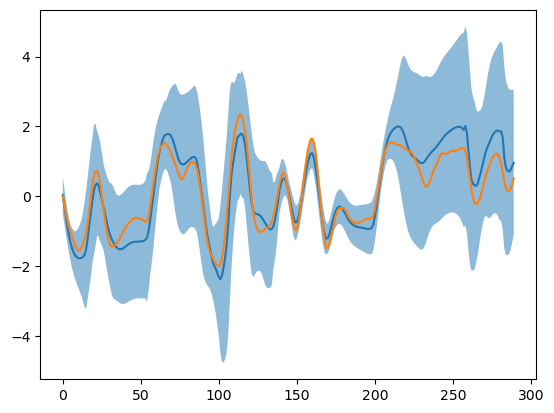

In [14]:
mean = out.y_dists[0].mean.numpy()
std = out.y_dists[0].stddev.numpy()

plt.fill_between(np.arange(mean.shape[0]), mean-std*2, mean+std*2 ,alpha=0.5)
plt.plot(mean)
plt.plot((out.yfuture[0].numpy()+np.pi)%(2*np.pi) - np.pi)

plt.show()

In [15]:
out = model.multi_step(System_data(u=u_realisation,y=y_realizations[:,0]),nf='sim')

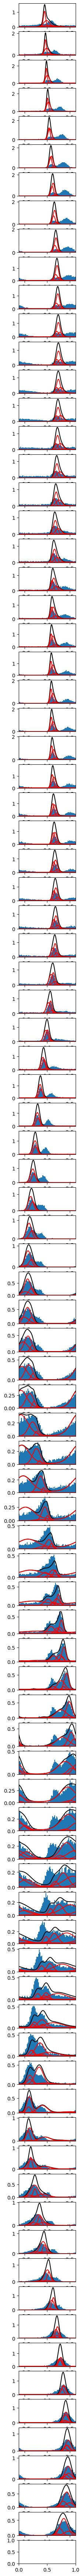

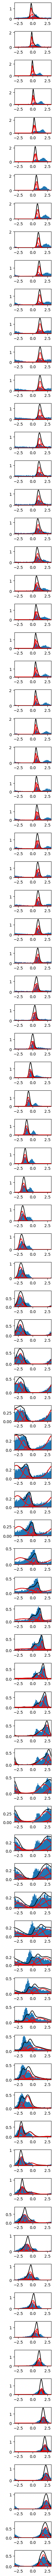

In [17]:
 
norm_angle = lambda x: (x + np.pi)%(2*np.pi) -np.pi
nplots = 90
off = max(model.na, model.nb) if isinstance(model, Meta_SS_model_encoder) else 0
plt.figure(figsize=(2,1*nplots))
ytest = torch.linspace(-np.pi, np.pi, 400)
for t in range(nplots):
    treal = t+off
    if isinstance(model, Meta_SS_model_encoder):
        tout = t+off-max(model.na, model.nb)
    else:
        tout = t+off
    plt.subplot(nplots,1,t+1)
    dist = out.y_dists[0,tout]
    assert abs(y_realizations[treal,0]-out.yfuture[0,tout].numpy())<1e-3
    plt.hist(norm_angle(y_realizations[treal]),density=True, bins=int(y_realizations.shape[1]**0.5))
    plt.plot(ytest.numpy(), dist.prob(ytest).numpy(),'k')
    plt.plot(ytest.numpy(), dist.prob_per_weighted(ytest).numpy(),'r')
    plt.xlim(-np.pi,np.pi)
plt.tight_layout()
plt.show()


In [97]:
fig, ax = plt.subplots(1,1,figsize=(5,6))
ax1 = ax
xdata, ydata = [], []
ln1, = ax1.plot([], [])
ln2, = ax1.plot([], [])
hist = ax1.hist()

TypeError: hist() missing 1 required positional argument: 'x'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation



fig, ax = plt.subplots(1,1,figsize=(5,6))
ax1, = ax
xdata, ydata = [], []
ln1, = ax1.plot([], [])
ln2, = ax1.plot([], [])
hist = ax1.hist()
ax1.set_xlim(-np.pi,np.pi)
ax1.set_ylim(0,1.3)
plt.tight_layout()

def init():
    return ln1, ln2, hist

off = 0
def update(t):
    treal = t+off
    tout = t+off#-max(model.na, model.nb)
    dist = out.y_dists[0,tout]
    assert abs(y_realizations[treal,0]-out.yfuture[0,tout].numpy())<1e-3

    hist.set_data(norm_angle(y_realizations[treal]),density=True, bins=int(y_realizations.shape[1]**0.5))
    plt.plot(ytest.numpy(), dist.prob(ytest).numpy(),'k')
    plt.plot(ytest.numpy(), dist.prob_per_weighted(ytest).numpy(),'r')
    plt.xlim(-2,2)
    
    dens, bins = np.histogram(xlists[:,i],bins=np.linspace(-10.5,10.5,200),density=True)
    ln1.set_data((bins[1:]+bins[:-1])/2,dens)
    ln3.set_data((bins[1:]+bins[:-1])/2,dens)
    th = (i - 30)/30*2*np.pi
    ln2.xy = (0.9*np.cos(th), 0.9*np.sin(th))
    return ln1, ln2, ln3

frames = list(range(30,60))
n_repeat = 10
frames = frames*n_repeat

ani = FuncAnimation(fig, update, frames=tqdm(frames),
                    init_func=init, blit=True, interval=1000/30)
file_name = 'figures/movie-pxt.mp4'
ani.save(file_name,dpi=200)
plt.close()
# from IPython.display import Video
# Video(file_name)

# from IPython import display
# html = display.HTML(ani.to_html5_video())
# display.display(html)
